# Notebook para la competición de Kaggle [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)
Identify metastatic tissue in histopathologic scans of lymph node sections

[Notebook de ayuda](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch/notebook)

# TODO

- Try Adam, lr = 2e-2
- Concact (Avg + Max) Adaptative pooling
- Aug
  - RandomDihedral
  - RandomRotate
- TTA

In [1]:
from javIA_oop import *

AI framework by Javi based in PyTorch: 0.4.1


In [2]:
class CancerDataset(ImageDataset):

	def __init__(self, img_dir, csv_name, transforms=False, limit=False):
		dataset_dir = pathlib.Path("C:/Users/Javi/Desktop/Datasets/PCam")
		csv_df      = pd.read_csv(dataset_dir / csv_name)

		self.image_dir  = dataset_dir / img_dir
		self.images     = (csv_df["id"]+".tif").values
		self.labels     = (csv_df["label"]).values
		self.labels_map = {0: "sano", 1: "cancer"}
		self.transforms = transforms
		self.limit      = limit

dataset = CancerDataset("train", "train_labels.csv")
test_ds = CancerDataset("test", "sample_submission.csv")
print("There are", len(dataset), "images in the labeled dataset.")
print("There are", len(test_ds), "images in the test dataset.")

There are 220025 images in the labeled dataset.
There are 57458 images in the test dataset.


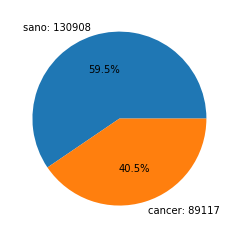

In [3]:
dataset.plot_balance()

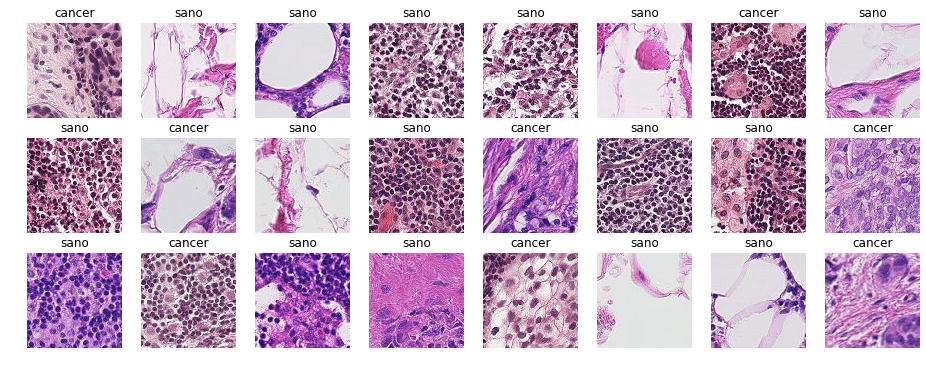

In [4]:
dataset.plot_images(columns=8, rows=3)

## Add transforms

In [5]:
data_transforms = transforms.Compose([
    #transforms.CenterCrop(32),
    transforms.Pad(64, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_transforms_test = transforms.Compose([
    #transforms.CenterCrop(32),
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset.transforms = data_transforms
test_ds.transforms = data_transforms_test

## Split in train/valid

In [6]:
train_ds, valid_ds = dataset.split(val_size=0.1)
print("There are", len(train_ds), "images in the train dataset.")
print("There are", len(valid_ds), "images in the validation dataset.")

There are 198022 images in the train dataset.
There are 22003 images in the validation dataset.


# Train

In [7]:
dl = DeepLearner("resnet34", train_ds, valid_ds, test_ds, batch_size=512) # "resnet18" batch_size=512

Total time: 25:49
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
epoch                                                                   (00:00)
Saving model!                                                           (14:34)
1/2	14:34	0.0667		0.5553	0.7480		0.4380	0.8782                          (00:00)
epoch                                                                   (00:00)
Saving model!                                                           (11:14)
2/2	25:49	0.0000		0.4880	0.8177		0.4283	0.8826                          (00:00)



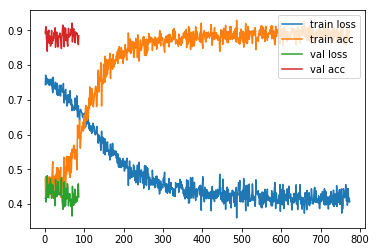

In [8]:
#dl.train_ds.limit=512
#dl.valid_ds.limit=512
dl.train(num_epochs=2, max_lr=0.1)

Total time: 3:06:49
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
epoch                                                                   (00:00)
Saving model!                                                           (1:09:30)
1/2	69:30	0.0667		0.2244	0.9622		0.1087	0.9915                          (00:00)
epoch                                                                   (00:00)
Saving model!                                                           (1:57:18)
2/2	186:49	0.0000		0.1674	0.9772		0.0986	0.9928                         (00:00)



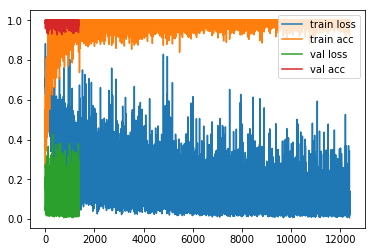

In [7]:
dl = DeepLearner("resnet34", train_ds, valid_ds, test_ds, batch_size=32) # "resnet18" batch_size=512
dl.train(num_epochs=2, max_lr=0.1)

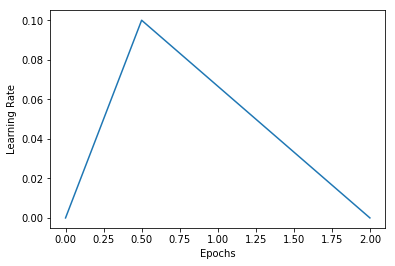

In [9]:
dl.plot_lr()

# Test

In [8]:
preds = dl.test_epoch()

100%|█████████████████████████████████████████████████████████████████████████████| 1796/1796 [05:52<00:00,  5.93it/s]


In [9]:
test_preds = pd.DataFrame({'id': test_ds.images, 'label': preds})
test_preds['id'] = test_preds['id'].apply(lambda x: x.split('.')[0])
test_preds.to_csv('PCam_sub.csv', index=False)
test_preds.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,-4.136719
1,95596b92e5066c5c52466c90b69ff089b39f2737,-3.646484
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,-11.429688
3,2c35657e312966e9294eac6841726ff3a748febf,-5.761719
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,-7.242188


# Fix sigmoid

In [17]:
# read old CSV
df      = pd.read_csv('PCam_sub.csv')
ids     = df["id"].values
preds   = df["label"].values
preds_t = torch.from_numpy(preds)

# convert
sig = torch.nn.Sigmoid()
new_preds = sig(preds_t).numpy()

# write new CSV
new_csv = pd.DataFrame({'id': ids, 'label': new_preds})
new_csv.to_csv('PCam_sub_sigmoid.csv', index=False)
new_csv.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.079496
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.536343
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.328960
3,2c35657e312966e9294eac6841726ff3a748febf,0.396010
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.204183
